In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # to print multiple outputs from the same cell
import math
import utils
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from operator import index
from collections import defaultdict
from scipy.stats import pearsonr
from datetime import datetime

In [2]:
tweets_df = pd.read_csv("dataset/tweets.csv")
users_df = pd.read_csv("dataset/users_dataset_cleaned.csv")

## Tweets Data Understanding and Preparation



In tweets.csv each row contains information about a single tweet. There are 10 columns and In this case the variables are:

1. ID: a unique identifier for the tweet

2. User Id: a unique identifier for the user who wrote the tweet

3. Retweet count: number of retweets for the tweet in analysis

4. Reply count: number of reply for the tweet in analysis

5. Favorite count: number of favorites (likes) received by the tweet

6. Num hashtags: number of hashtags used in the tweet

7. Num urls: number of urls in the tweet

8. Num mentions: number of mentions in the tweet

9. Created at: when the tweet was created

10. Text: the text of the tweet


### Attribute type and quality

In [3]:
tweets_df.info(verbose=True, show_counts=True, memory_usage= "deep") 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13664696 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   id              13664694 non-null  object
 1   user_id         13447413 non-null  object
 2   retweet_count   13227562 non-null  object
 3   reply_count     13016818 non-null  object
 4   favorite_count  13017154 non-null  object
 5   num_hashtags    12607172 non-null  object
 6   num_urls        13016073 non-null  object
 7   num_mentions    12810531 non-null  object
 8   created_at      13664696 non-null  object
 9   text            13126975 non-null  object
dtypes: object(10)
memory usage: 8.9 GB


## 1. Tweet_id & User_id Columns

keeping only the tweets with user_id in user dataset. As these are the ones we would like to study, and have the data to verify the validity of.

In [4]:
tweets_df.rename(columns= {"id" : "tweet_id"}, inplace=True)

In [5]:
before_dropping_rows_number = len(tweets_df.index)

numeric_ids = pd.to_numeric(tweets_df["user_id"], errors="coerce")
ids_are_not_in_users_df = numeric_ids[numeric_ids.isin(users_df["user_id"]) == False]
tweets_df.drop(ids_are_not_in_users_df.index, inplace=True)

tweets_df["user_id"] = pd.to_numeric(tweets_df["user_id"], errors="coerce")

after_dropping_rows_number = len(tweets_df.index)

print(f"Percentage of tweets whose author id isn't inside the users dataframe: {(100*(before_dropping_rows_number-after_dropping_rows_number))/(before_dropping_rows_number)}")

Percentage of tweets whose author id isn't inside the users dataframe: 3.56021092602426


These tweets are dropped from the tweets dataframe.

clean id field by casting to int

In [6]:
tweets_df["tweet_id"] = pd.to_numeric(tweets_df["tweet_id"], errors="coerce") # cast field to int and set invalid values to NaN

removing tweets which are duplicates on every attribute

In [7]:
original_number_rows = len(tweets_df.index)

all_columns_duplicated_df = tweets_df[tweets_df.duplicated(subset=None, keep="first")]
all_columns_duplicated_number = len(all_columns_duplicated_df.index)

print(f"Percentage of tweets duplicated along all the columns that we are deleting(after keeping the first instance): {(100*(all_columns_duplicated_number))/original_number_rows}")

tweets_df.drop(labels=all_columns_duplicated_df.index, inplace=True)

Percentage of tweets duplicated along all the columns that we are deleting(after keeping the first instance): 14.75545529572922


Dropping tweets whose id is an invalid value (i.e. NaN, duplicate, inf)

In [8]:
before = tweets_df.size
tweets_df = tweets_df[tweets_df['tweet_id'].notna()]
after= tweets_df.size
print(f"Percentage of tweets with nan tweet_id dropped: {(100*(before - after))/before}")

Percentage of tweets with nan tweet_id dropped: 3.333923818510375


In [9]:
before = tweets_df.size
tweets_df = tweets_df.drop_duplicates(subset="tweet_id")
after = tweets_df.size
print(f"Num of tweets with same tweet_id dropped: {(before - after)}")

Num of tweets with same tweet_id dropped: 5480


In [10]:
before = tweets_df.size
tweets_df = tweets_df[tweets_df['tweet_id']!=np.inf]
after = tweets_df.size
print(f"Num of tweets with inf tweet_id dropped: {(before - after)}")

Num of tweets with inf tweet_id dropped: 10


We have decided to drop all tweets with NaN values as their ID. As it is difficult for us to ensure their validity. We have also decided to drop all tweets with duplicated IDs. Keeping only its first instance. 

As we can see from the data above. Pandas treats tweets with fields containing NaN values as different from each other. Atleast when it comes to ID. 

Lets see if we can find the tweets with non-NaN user-id values.

In [11]:
before = tweets_df.size
tweets_df = tweets_df[tweets_df['user_id'].notna()]
after= tweets_df.size
print(f"Percentage of tweets with nan user_id dropped: {(100*(before - after))/before}")

Percentage of tweets with nan user_id dropped: 0.0


Convert tweet_id attribute to int64

In [12]:
tweets_df["tweet_id"] = tweets_df["tweet_id"].astype(np.int64)
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10858628 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tweet_id        int64 
 1   user_id         int64 
 2   retweet_count   object
 3   reply_count     object
 4   favorite_count  object
 5   num_hashtags    object
 6   num_urls        object
 7   num_mentions    object
 8   created_at      object
 9   text            object
dtypes: int64(2), object(8)
memory usage: 911.3+ MB


## 3. Numerical columns

- Retweet_count
- Reply_count
- favorite_count
- Num_hashtags
- Num_urls
- num_mentions

In [13]:
columns = ["retweet_count", "reply_count", "favorite_count", "num_hashtags", "num_urls", "num_mentions"]
tweets_df[columns].describe()

,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions
count,10589137,10480176,10479682,10259406,10479097,10369957
unique,181213,117598,117707,77700,116554,97775
top,0,0,0,0,0,0
freq,7540373,9803698,7866508,8704828,8223780,6116212


The following thresholds are based on the most retweet and "liked" tweets on the twitter platform

In [14]:
thresholds = {
   "retweet_count": 3738380,
   "favorite_count": 7114892
}

print("Number of invalid values for the following columns:")
for column_name in columns:
   # casting all the columns to numeric (and setting invalid value to null)
   tweets_df[column_name] = pd.to_numeric(tweets_df[column_name], errors="coerce")

   print(f"{column_name}")
   # evaluating the presence of negative values
   negative_series = tweets_df[tweets_df[column_name] < 0][column_name]
   print(f"\tnegative: {negative_series.size}")
   tweets_df[column_name].loc[negative_series.index] = np.NaN # setting negative values to NaN
   
   # evaluating the presence of inf values
   inf_series = utils.get_inf_elements(tweets_df[column_name])
   print(f"\tinf: {inf_series.size}")
   tweets_df[column_name].loc[inf_series.index] = np.NaN # setting inf values to NaN

   # evaluating the presence of decimal values
   is_float = lambda n: (not pd.isna(n)) and (not math.isinf(n)) and (not n.is_integer())
   decimal_values_series =  tweets_df[column_name].apply(is_float)
   print(f"\tdecimals: {tweets_df[column_name][decimal_values_series].size}")
   
   # finding values above given thresholds (if specified)
   if column_name in thresholds:
       threshold = thresholds[column_name]
       above_threshold_series = tweets_df[tweets_df[column_name] > threshold ][column_name]
       print(f"\tvalues above threshold ({threshold}): {above_threshold_series[above_threshold_series > threshold].size}") 
       tweets_df[column_name].loc[above_threshold_series.index] = np.NaN # setting values above threshold to nan



Number of invalid values for the following columns:
retweet_count
	negative: 0


/tmp/ipykernel_22391/414869727.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df[column_name].loc[negative_series.index] = np.NaN # setting negative values to NaN


	inf: 1


/tmp/ipykernel_22391/414869727.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df[column_name].loc[inf_series.index] = np.NaN # setting inf values to NaN


	decimals: 0
	values above threshold (3738380): 36


/tmp/ipykernel_22391/414869727.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df[column_name].loc[above_threshold_series.index] = np.NaN # setting values above threshold to nan


reply_count
	negative: 0
	inf: 1
	decimals: 0
favorite_count
	negative: 1
	inf: 0
	decimals: 0
	values above threshold (7114892): 34
num_hashtags
	negative: 0
	inf: 0
	decimals: 0
num_urls
	negative: 0
	inf: 0
	decimals: 0
num_mentions
	negative: 0
	inf: 0
	decimals: 0


The first observation that can be made is that \*_count and num_\* fields should contain only positive integers. Something that they do.
We find some inf values in the following columns:
- retweet_count
- reply_count

We also find values that are above our treshold range: 
- 36 tweets above the retweet_count treshold
- 34 tweets above the favorite_count treshold


All these values and the infinate values are set to NaN.


### Parsing columns to integer

Substituting NaN values with median

In [15]:
for column in columns:
    column_median_value = tweets_df[column].median()
    tweets_df[column] = tweets_df[column].fillna(column_median_value)
    # parsing column type to int
    tweets_df[column] = tweets_df[column].astype(np.int64)

## 4. Created_at Column

created_at should be datetime

Checks if all the tweets were created after the first tweet published on twitter (so we don't have something strange like a tweet created in 01-01-1990)

In [16]:
tweets_df["created_at"] = pd.to_datetime(tweets_df["created_at"], errors="coerce")

# finding tweets created before twitter first tweet
before_time_tweets_df = tweets_df[tweets_df["created_at"] < datetime(2006,3,21,12,50,0)]

# finding tweets created after dataset release
after_time_tweets_df = tweets_df[tweets_df["created_at"] > datetime(2022,9,29,11,0,0)]

# dropping out of range tweets
tweets_df = tweets_df.drop(before_time_tweets_df.index)
tweets_df = tweets_df.drop(after_time_tweets_df.index)

## 5. Text Column

In [17]:
tweets_df.info(verbose=True, show_counts=True, memory_usage= "deep") 
tweets_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10761030 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Non-Null Count     Dtype         
---  ------          --------------     -----         
 0   tweet_id        10761030 non-null  int64         
 1   user_id         10761030 non-null  int64         
 2   retweet_count   10761030 non-null  int64         
 3   reply_count     10761030 non-null  int64         
 4   favorite_count  10761030 non-null  int64         
 5   num_hashtags    10761030 non-null  int64         
 6   num_urls        10761030 non-null  int64         
 7   num_mentions    10761030 non-null  int64         
 8   created_at      10761030 non-null  datetime64[ns]
 9   text            10460638 non-null  object        
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 2.2 GB


,tweet_id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions
count,1.076103e+07,1.076103e+07,1.076103e+07,1.076103e+07,1.076103e+07,1.076103e+07,1.076103e+07,1.076103e+07
mean,4.699847e+17,8.304019e+08,5.541874e+02,-8.106447e+12,3.421834e+00,-5.999761e+12,-9.428195e+12,-5.142651e+12
std,1.693284e+17,8.521113e+08,1.399422e+04,9.020946e+15,3.056932e+03,7.438951e+15,9.325217e+15,6.887131e+15
min,3.460000e+02,6.780330e+05,0.000000e+00,-9.223372e+18,0.000000e+00,-9.223372e+18,-9.223372e+18,-9.223372e+18
25%,4.614611e+17,2.371780e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.243933e+17,4.680662e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.773086e+17,1.200888e+09,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,9.999952e+17,3.164942e+09,3.350111e+06,5.000000e+18,7.000000e+06,7.540000e+11,7.102000e+12,4.000000e+12


Removing tweets with null text field, float text field or only spaces, because these are not allowed by twitter

In [18]:
tweets_df.dropna(subset=["text"], inplace=True) # drop the tweets where the text field is null
tweets_df["text"] = tweets_df["text"].astype(str) # cast the text field to string
tweets_df = tweets_df[~tweets_df.text.str.isspace()]

tweets_df.info(verbose=True, show_counts=True, memory_usage= "deep") 
tweets_df.describe()
# Problem with memory usage, we have to find a more effient way to remove tweets with only spaces
# We should also drop the tweets only containing the U+3164 HANGUL FILLER, or other invisible charackters.
#Source: https://invisible-characters.com/
"""
to_drop = []
for index, row in tweets_df.iterrows():
    if row["text"].isspace():
        tweets_df.drop(index)
"""

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10460637 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Non-Null Count     Dtype         
---  ------          --------------     -----         
 0   tweet_id        10460637 non-null  int64         
 1   user_id         10460637 non-null  int64         
 2   retweet_count   10460637 non-null  int64         
 3   reply_count     10460637 non-null  int64         
 4   favorite_count  10460637 non-null  int64         
 5   num_hashtags    10460637 non-null  int64         
 6   num_urls        10460637 non-null  int64         
 7   num_mentions    10460637 non-null  int64         
 8   created_at      10460637 non-null  datetime64[ns]
 9   text            10460637 non-null  object        
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 2.2 GB


,tweet_id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions
count,1.046064e+07,1.046064e+07,1.046064e+07,1.046064e+07,1.046064e+07,1.046064e+07,1.046064e+07,1.046064e+07
mean,4.797205e+17,8.292025e+08,5.587867e+02,-8.339236e+12,3.399007e+00,-6.172053e+12,-6.172052e+12,-5.290330e+12
std,1.562082e+17,8.513559e+08,1.394357e+04,9.149554e+15,3.099434e+03,7.545005e+15,7.545005e+15,6.985318e+15
min,3.460000e+02,6.780330e+05,0.000000e+00,-9.223372e+18,0.000000e+00,-9.223372e+18,-9.223372e+18,-9.223372e+18
25%,4.680207e+17,2.364496e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.257476e+17,4.680642e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.777142e+17,1.199715e+09,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,9.999952e+17,3.164942e+09,3.350111e+06,5.000000e+18,7.000000e+06,7.540000e+11,7.102000e+12,4.000000e+12


'\nto_drop = []\nfor index, row in tweets_df.iterrows():\n    if row["text"].isspace():\n        tweets_df.drop(index)\n'

### Distribution of variables and statistics
Let's study them!

Histograms for numerical fields

array([[<AxesSubplot: title={'center': 'retweet_count'}>,
        <AxesSubplot: title={'center': 'reply_count'}>],
       [<AxesSubplot: title={'center': 'favorite_count'}>,
        <AxesSubplot: title={'center': 'num_hashtags'}>],
       [<AxesSubplot: title={'center': 'num_urls'}>,
        <AxesSubplot: title={'center': 'num_mentions'}>]], dtype=object)

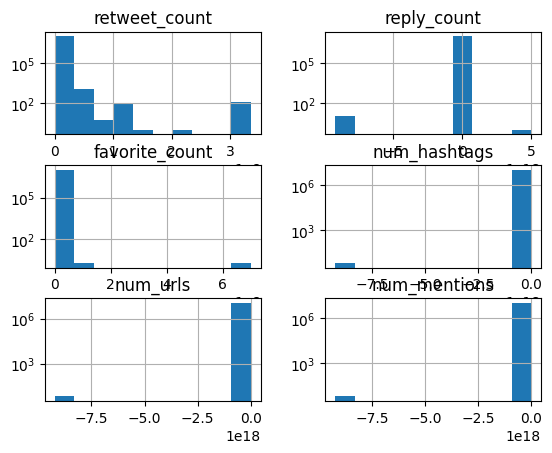

In [19]:
columns = ["retweet_count", "reply_count", "favorite_count", "num_hashtags", "num_urls", "num_mentions"]

tweets_df.hist(
    column=columns, 
    log=True,
    #bins=utils.get_sturges_bins(tweets_df.size)
)

Boxplots for the numerical fields.

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

<AxesSubplot: >

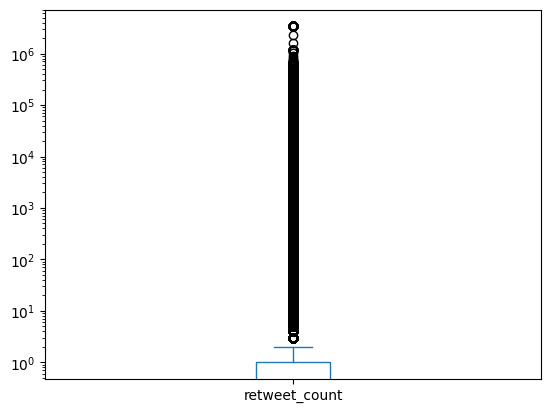

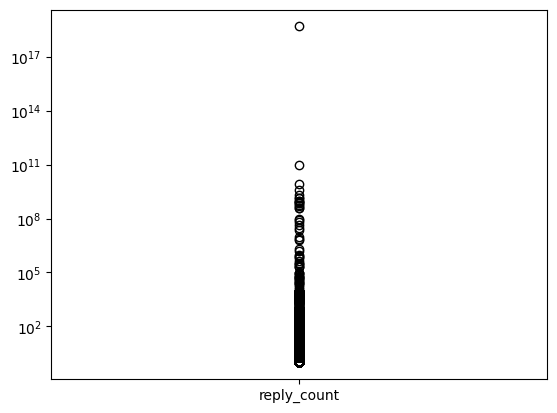

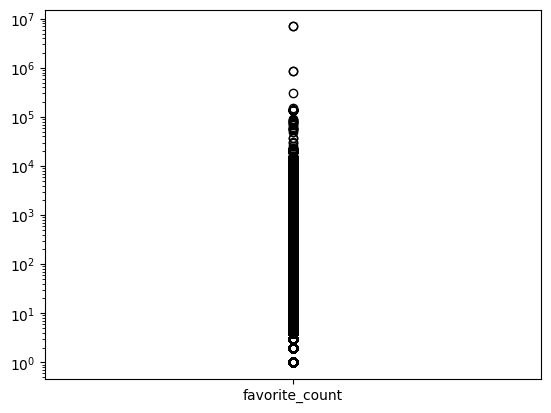

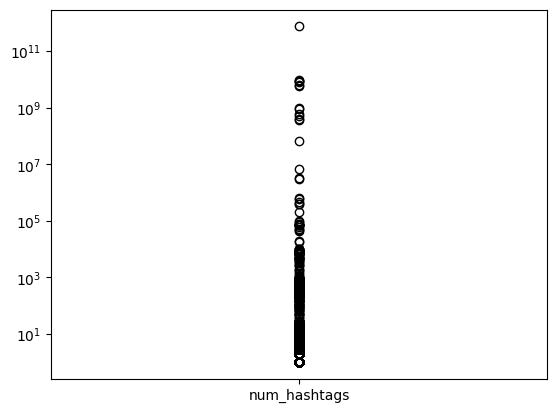

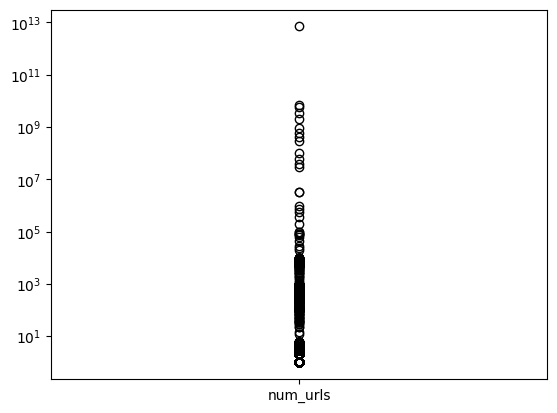

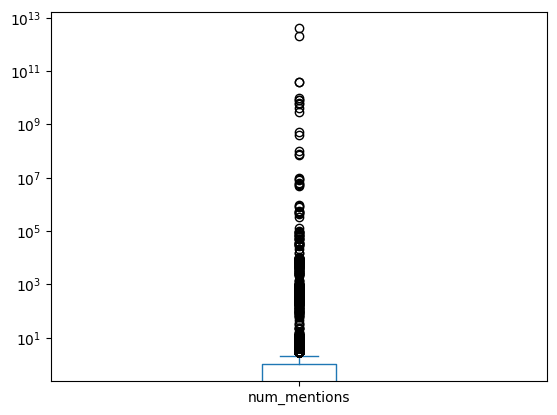

In [20]:
for column in columns:
    tweets_df.plot(kind="box",
        column=column,
        logy=True
    )

By looking at the boxplots we can see that there is a very high variance for the data (an observation supported also by the previous histograms). Hence, we compute the whiskers upper and lower bounds analitically for each column.

In [21]:
# outlier detection
outlier_thresholds = {
    column: utils.compute_whiskers(tweets_df[column])
    for column in columns
}

outlier_dataframes = {
    column: tweets_df[tweets_df[column] > outlier_thresholds[column][1]][column]
    for column in columns
}

for column in columns:
    print(f"{column}: {len(outlier_dataframes[column])} outliers")

# Should add what percentage of the dataframe that this consists of.
# In this way we get a feeling of how many outliers our cleaned dataset consists of


retweet_count: 1630360 outliers
reply_count: 16939 outliers
favorite_count: 1996603 outliers
num_hashtags: 1135453 outliers
num_urls: 1646159 outliers
num_mentions: 232088 outliers


These outliers may be removed from the dataframe by running the code block bellow.

In [22]:
# # removal of outliers
# outlier_indexes_list = [outlier_dataframe.index for outlier_dataframe in outlier_dataframes.values()]
# for indexes in outlier_indexes_list:
#     tweets_df.drop(indexes, inplace=True, errors="ignore")

## Tweet Data Quality Summary

In [23]:
tweets_df.info(verbose=True, show_counts=True, memory_usage= "deep") 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10460637 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Non-Null Count     Dtype         
---  ------          --------------     -----         
 0   tweet_id        10460637 non-null  int64         
 1   user_id         10460637 non-null  int64         
 2   retweet_count   10460637 non-null  int64         
 3   reply_count     10460637 non-null  int64         
 4   favorite_count  10460637 non-null  int64         
 5   num_hashtags    10460637 non-null  int64         
 6   num_urls        10460637 non-null  int64         
 7   num_mentions    10460637 non-null  int64         
 8   created_at      10460637 non-null  datetime64[ns]
 9   text            10460637 non-null  object        
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 2.2 GB


In [24]:
# This codeblock should compute the number of tweets belonging to human and bot accounts
# It should also compute the percentage of this data, to come up with a number for balance

# We also have to decide if we should remove the remaining tweets that include NaN values.
# These are around 400 thousand of our 10 million four hundred thousand remaining tweets.
# So basically less than 4%

# Number_of_users_in_dataset_that_are_bots = users_df.groupby("bot").get_group(1)
# Number_of_users_in_dataset_that_are_humans = users_df.groupby("bot").get_group(0)
# total = len(Number_of_users_in_dataset_that_are_bots) + len(Number_of_users_in_dataset_that_are_humans)
# print(f"Out of the {total} users in our dataset. {len(Number_of_users_in_dataset_that_are_humans)} are humans, and {len(Number_of_users_in_dataset_that_are_bots)} are bots.")
# print(f"The dataset consists of {round(100*(len(Number_of_users_in_dataset_that_are_humans)/total),3)}% humans and {round(100*(len(Number_of_users_in_dataset_that_are_bots)/total),3)}% bots respectively.")
# print(f"399 of our users are missing their statuses_count values. These humans consist of {round(100*(len(list_of_humans)/total),3)}% of our dataset.")
# print(f"These users will be removed.")

This block should explain the the state of the cleaned and generalized dataset. Also stating how balanced it is.

From the users cleaning notebook
.......................................
After cleaning we are left with a "fairly" balanced and generalized dataset, that is ready for further use. The dataset contains approx. 45% human and 55% bot users. 
.......................................

In [25]:
tweets_df.to_csv("./dataset/tweets_dataset_cleaned.csv",index=False)